In [1]:
# imports
import numpy as np
import random
import math
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import display, clear_output
#import autograd.numpy as np
#from autograd import elementwise_grad as grad, value_and_grad

In [2]:
# Read data functions
def string_to_spin(string):
    """
    Convert string of 0 and 1 to a np array of spins (-1, 1):
    0 -> -1
    1 -> +1
    :param string: String: original string.
    :return: np.array: Spins.
    """
    return (np.array(list(map(int, list(string)))) * 2 - 1)

def read_configurations(name, n):
    """
    Reads a file and returns a np array with the spin configuration.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Matrix of shape (Data_number, num_spins).
    """
    spins = np.array([])
    filepath = name
    with open(filepath, 'r') as fp:
        s = fp.readlines()  
    spins = np.array([string_to_spin(e.rstrip()) for e in s]).flatten()
    return np.reshape(spins, (int(len(spins)/n), n)).astype('int')

def read_j_coef(name, n):
    """
    Reads a file and returns a np array with the j coefficients.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Array of shape 2*n.
    """
    j = np.zeros((n, 2))
    filepath = name
    with open(filepath) as fp:
        for line in tqdm_notebook(fp.readlines()):
            list_line = line.split()
            if len(list_line) == 2:
                el = list_line[-1]
                list_line[-1] = el[0]
                list_line.append(el[1:])
            s = int(list_line[0])-1
            d = int(list_line[1])-1
            # list line té 3 llocs: numspin, (1 o 2) i el valor de J
            j[s, d] = list_line[-1]
    return j

In [3]:
# get neighbours
def get_spin_neighbours(i, l):
    """
    From a spin i in a lxl grid, gives the neighbours of this spin.
    :param i: Int: Position of the spin.
    :param l: Int: Length of the square grid.
    :return: np.array: Array containing the index of the neighbour spins.
    """
    column = int(i % l)
    row = int(i / l)
    right = int(row * l + (column + 1)%l)
    up = int(((row + 1)%l) * l + column)
    left = int(row * l + (column - 1)%l)
    down = int(((row - 1)%l) * l + column)
    return np.array([right, up, left, down])

def f_nbrs(n):
    l = int(np.sqrt(n))
    return np.array([get_spin_neighbours(i, l) for i in range(n)])

In [4]:
print(f_nbrs(16))

[[ 1  4  3 12]
 [ 2  5  0 13]
 [ 3  6  1 14]
 [ 0  7  2 15]
 [ 5  8  7  0]
 [ 6  9  4  1]
 [ 7 10  5  2]
 [ 4 11  6  3]
 [ 9 12 11  4]
 [10 13  8  5]
 [11 14  9  6]
 [ 8 15 10  7]
 [13  0 15  8]
 [14  1 12  9]
 [15  2 13 10]
 [12  3 14 11]]


In [5]:
# Pseudolikelihood calculation
def log_pseudolikelihood(data, nbrs, h, j, temp=1):
    """Sums the rows of the pseudolikelihood"""
    m, n = data.shape
    output = np.array([[1 + data[mu, i] * math.tanh(float(h[i])/temp + multiply_j_spin_neighbours(j, data[mu, :], i, nbrs[i])/temp) for i in range(n)] for mu in range(m)])
    output = np.log(output)
    return -np.sum(output)/m

def multiply_j_spin_neighbours(j, spins, i, nbr):
    n, d = j.shape
    subsum = 0
    for k in range(d):
        subsum += spins[nbr[k]] * j[i, k] + spins[nbr[k + d]] * j[nbr[k + d], k]
    return float(subsum)

def pseudolikelihood_gradient_descent(j, data, nbrs, temp):
    m, n = data.shape
    h = np.zeros(n)
    return log_pseudolikelihood(data, nbrs, h, j, temp=temp)

def pseudolikelihood_gradient_descent_penalty(j, data, nbrs, temp, penalty=1.):
    m, n = data.shape
    h = np.zeros(n)
    return log_pseudolikelihood(data, nbrs, h, j, temp=temp) + penalty * np.sum(j**2)

In [6]:
def index_array_to_matrix(n, pair):
    l = int(np.sqrt(n))
    out = [-1, -1]
    out[0] = pair[0]
    if pair[1] == 0:
        out[1] = int(pair[0]/l)*l + ((pair[0] + 1)%l)
    else:
        out[1] = ((pair[0] + l)%n)
    return out
    
def jacobian_pseudo(j, data, nbrs, temp):
    m, n = data.shape
    jac = np.zeros((n,2))
    for a in range(n):
        for b in range(2):
            k, l = index_array_to_matrix(n, [a, b])
            subsum = 0
            for mu in range(m):
                tanh_k = math.tanh(multiply_j_spin_neighbours(j, data[mu, :], k, nbrs[k])/temp)
                tanh_l = math.tanh(multiply_j_spin_neighbours(j, data[mu, :], l, nbrs[l])/temp)
                subsum += data[mu, k]*data[mu, l] * ((1-tanh_k**2)/(1 + data[mu, k]*tanh_k) + (1-tanh_l**2)/(1 + data[mu, l]*tanh_l))
            jac[a, b] = -float(subsum)/m
    
    return jac/np.linalg.norm(jac)

def jacobian_pseudo_penalty(j, data, nbrs, temp, penalty=1.):
    m, n = data.shape
    jac = np.zeros((n,2))
    for a in range(n):
        for b in range(2):
            k, l = index_array_to_matrix(n, [a, b])
            subsum = 0
            for mu in range(m):
                tanh_k = math.tanh(multiply_j_spin_neighbours(j, data[mu, :], k, nbrs[k])/temp)
                tanh_l = math.tanh(multiply_j_spin_neighbours(j, data[mu, :], l, nbrs[l])/temp)
                subsum += data[mu, k]*data[mu, l] * ((1-tanh_k**2)/(1 + data[mu, k]*tanh_k) + (1-tanh_l**2)/(1 + data[mu, l]*tanh_l))
            jac[a, b] = -float(subsum)/m + penalty * 2 * j[a,b]
    
    return jac/np.linalg.norm(jac)

In [7]:
#for i in range(64):
#    for j in range(2):
#        print('({},{}) -> ({},{})'.format(i, j, index_array_to_matrix(64, [i,j])[0], index_array_to_matrix(64, [i,j])[1]))

In [8]:
def hamiltonian(spins, h, j):
    hamiltonian = 0
    n, d = j.shape
    l = int(np.sqrt(n))
    for i in range(n):
        subsum = 0
        for k in range(d):
            subsum += spins[get_spin_neighbours(i, l)[k]] * j[i, k]
        hamiltonian += spins[i] * subsum
    hamiltonian += np.dot(h, spins)
    return -hamiltonian

In [9]:
# Create random h and J of given dimension
def get_random_h_j(n, d=2):
    h = np.random.uniform(-1, 1, size=n)
    j = np.random.uniform(-1, 1, size=(n,d))
    return h, j

def mean_error(h, j, hp, jp, magnetic_field=True):
    numerator = np.linalg.norm(flat_matrix(j) - flat_matrix(jp))**2 + np.linalg.norm(h-hp)**2
    denominator = np.linalg.norm(flat_matrix(jp))**2 + np.linalg.norm(hp)**2
    return np.sqrt(numerator/denominator)


def neighbour_uniform(s, delta=0.5):
    lower = max(s - delta, -1.)
    upper = min(s + delta, 1.)
    return np.random.uniform(lower, upper)

def random_change_h_j_row(h, j, nbrs, delta=0.5, magnetic_field=True):
    if magnetic_field:
        h_new = np.copy(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d+1)
        if row == d:
            # h must be changed
            h_new[column] = neighbour_uniform(h_new[column], delta)
            return h_new, j_new, (column,)
        else:
            # j must be changed
            j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
            return h_new, j_new, (column, nbrs[column][row])
    else:
        h_new = np.zeros_like(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d)
        # j must be changed
        j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
        return h_new, j_new, (column, nbrs[column][row])
    
def energy(temp, func, func_new):
    return math.exp(-(func_new - func) / temp)

In [10]:
def flat_matrix(a):
    return a.flatten()

In [11]:
def write_error_to_file(filename, error):
    f = open(filename, "w+")
    for e in error:
        f.write(str(e)+"\n")
    f.close()
def read_error_from_file(filename):
    with open(filename, 'r') as fp:
        s = fp.readlines()
    return np.array([e.strip() for e in s], dtype='float')

In [12]:
def write_arr_to_file(filename, arr1, arr2):
    f = open(filename, "w+")
    for e1, e2 in zip(arr1, arr2):
        f.write(str(e1)+' '+str(e2)+"\n")
    f.close()
def read_arr_from_file(filename):
    arr1 = []
    arr2 = []
    with open(filename, 'r') as fp:
        s = fp.readlines()
    for e in s:
        arr1.append(e.split()[0])
        arr2.append(e.split()[1])

    return np.array(arr1, dtype='float'), np.array(arr2, dtype='float')

In [13]:
def gradient_descent(f, gradient, x, j_real, eps=1e-6, max_iter=100, initial_alpha=0.1):
    """
    Aquesta funció implementa l'algorisme de descens pel gradient.
    
    :param f: Funció a minimitzar
    :param x: Punt inicial
    :param eps: Moviment mínim realitzat abans de parar
    :param max_iter: Iteracions màximes a realitzar
    :param initial_alpha: Pas inicial a cada iteració, corresponent al punt 3 anterior
    :param verbose: En case de ser True, la funció ha d'imprimir el nombre d'iteracions fetes
        abans de retornar
    :return: La funció retornarà el punt mínim.

    """
    h = np.zeros(1)
    point = x #Point serà l'últim punt trobat i next_point el següent que calculem a partir de point
    points = np.array([point]) #Definim un vector amb els punts trobats, per començar el punt inicial
    next_point = x + eps #Per poder entrar al bucle
    error = [mean_error(h, point, h, j_real)]
    alpha = initial_alpha
    change_alpha=[0]
    for iters in tqdm_notebook(range(max_iter)):
        point = points[-1]
        grad_p = gradient(point)
        next_point = point-alpha*grad_p
        #next_point = interval(next_point)
        while f(next_point) > f(point):
            alpha /= 1.5
            next_point = point-alpha*grad_p
            #next_point = interval(next_point)
            change_alpha.append(iters)
        points = np.append(points, [next_point], axis=0)
        error.append(mean_error(h, next_point, h, j_real))
        #if iters%10 == 0:
            #print(next_point, f(next_point), error[-1])
        #if np.linalg.norm(point-next_point)>eps:
            #break
        
    return points[-1], f(points[-1]), np.array(error), np.array(change_alpha)

In [14]:
def interval(j):
    j[j<-1] = -1
    j[j>1] = +1
    return j

In [15]:
size_sample = 1250
max_iterations = 800
n = 16
t1, t2, t3 = 0.5, 1.08304286, 2.0
j1 = read_j_coef('L4/sample1/bonds.dat', n)
h = np.zeros(n)
spins = read_configurations('L4/sample1/configurations_T1.dat', n)
spins = spins[::4]# en el cas de n=16
sample1 = spins[np.random.choice(spins.shape[0], size=size_sample, replace=False), :]
print(sample1.shape)


(1250, 16)


In [16]:
"""
print(pseudolikelihood_gradient_descent_penalty(j1, sample1, f_nbrs(n), temp=t1))
n = 16
max_i = 10
for i in range(max_i):
    j = np.random.uniform(-1, 1, size=(n,2))
    jaco = jacobian_pseudo_penalty(j, sample1, f_nbrs(n), temp=0.5)
    #print(jaco)

    print(pseudolikelihood_gradient_descent_penalty(j, sample1, f_nbrs(n), temp=t1) - pseudolikelihood_gradient_descent_penalty(j - 0.1*jaco, sample1, f_nbrs(n), temp=t1))
"""

'\nprint(pseudolikelihood_gradient_descent_penalty(j1, sample1, f_nbrs(n), temp=t1))\nn = 16\nmax_i = 10\nfor i in range(max_i):\n    j = np.random.uniform(-1, 1, size=(n,2))\n    jaco = jacobian_pseudo_penalty(j, sample1, f_nbrs(n), temp=0.5)\n    #print(jaco)\n\n    print(pseudolikelihood_gradient_descent_penalty(j, sample1, f_nbrs(n), temp=t1) - pseudolikelihood_gradient_descent_penalty(j - 0.1*jaco, sample1, f_nbrs(n), temp=t1))\n'

In [17]:
max_iterations = 200
nbrs = f_nbrs(n)
#result1 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=2.),
#                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=2.),
#                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result2 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=1.),
                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=1.),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
#result3 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.5),
#                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.5),
#                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result4 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.1),
                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
#result5 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.05),
#                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.05),
#                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
#result6 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.01),
#                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.01),
#                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
#result7 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.005),
#                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.005),
#                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result8 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.001),
                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.001),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
#result9 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.0005),
#                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.0005),
#                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result10 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.000),
                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.000),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)

In [18]:
result6 = gradient_descent(lambda j: pseudolikelihood_gradient_descent_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.01),
                          lambda j: jacobian_pseudo_penalty(j, sample1, nbrs=nbrs, temp=t1, penalty=0.01),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)

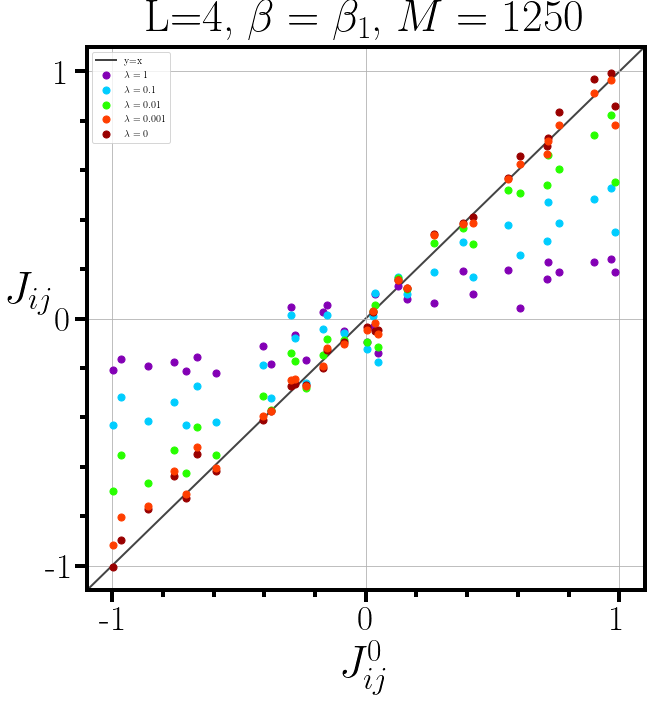

0.2401750021484152
0.5277953874227032
0.8235298353660305
0.9667663896743315
1.0052487455358405


In [41]:
colors_dif = [[255,0,0], [255,91,0], [255,198,0], [198,255,0], [91,255,0], [0,255,0], [0,255,91], [0,255,198], [0,198,255], [0,91,255]]
colors_dif = np.array(colors_dif)/255.0
colors_sp = ['#8300b5', '#0a00ff', '#00cdff', '#28ff00', '#b6ff00', '#ffcf00', '#ff3e00', '#ff0000','#990000', '#440000']
plt.figure(figsize = (10, 10))
mk_size=50
ax = plt.axes()
plt.title(r'L=4, $\beta=\beta_1$, $M=1250$', fontsize=45, y=1.005)
plt.xlabel(r'$J^{0}_{ij}$', rotation=0, fontsize=45)
plt.ylabel(r'$J_{ij}$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)
plt.plot((-1.1, 1.1), (-1.1,1.1), color='#444444', label=r'y=x', zorder=1, linewidth=2, alpha=1)
plt.scatter(flat_matrix(j1), flat_matrix(result2[0]), color=colors_sp[0], label=r'$\lambda = 1$', zorder=2, marker="o", s=mk_size)
plt.scatter(flat_matrix(j1), flat_matrix(result4[0]), color=colors_sp[2], label=r'$\lambda = 0.1$', zorder=3, marker="o", s=mk_size)
plt.scatter(flat_matrix(j1), flat_matrix(result6[0]), color=colors_sp[3], label=r'$\lambda = 0.01$', zorder=4, marker="o", s=mk_size)
plt.scatter(flat_matrix(j1), flat_matrix(result8[0]), color=colors_sp[6], label=r'$\lambda = 0.001$', zorder=6, marker="o", s=mk_size)
plt.scatter(flat_matrix(j1), flat_matrix(result10[0]), color=colors_sp[8], label=r'$\lambda = 0$', zorder=5, marker="o", s=mk_size)

plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
plt.grid()
plt.legend()
plt.savefig('scatter_plots_penalty.png', bbox_inches = 'tight')
plt.show()
print(np.max(np.abs(result2[0])))
print(np.max(np.abs(result4[0])))
print(np.max(np.abs(result6[0])))
print(np.max(np.abs(result8[0])))
print(np.max(np.abs(result10[0])))

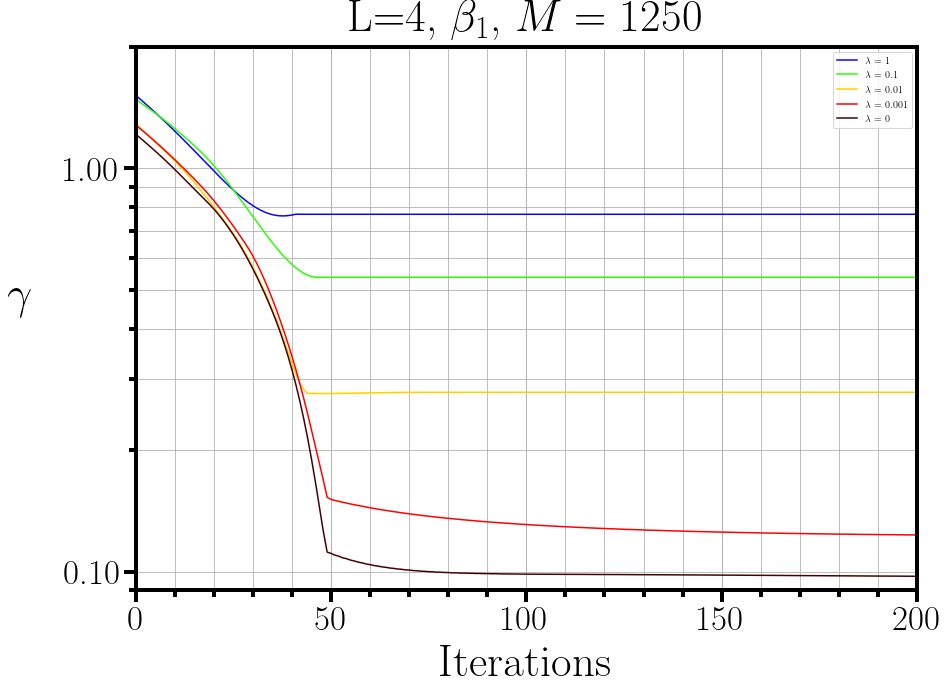

In [36]:
x = np.arange(len(result2[2]))
wl=2
color1, color2, color3 = '#bb0000', '#00bb00', '#0000bb'
colors_sp = ['#8300b5', '#0a00ff', '#00cdff', '#28ff00', '#b6ff00', '#ffcf00', '#ff3e00', '#ff0000','#990000', '#440000']
colors_dif = [[255,0,0], [255,91,0], [255,198,0], [198,255,0], [91,255,0], [0,255,0], [0,255,91], [0,255,198], [0,198,255], [0,91,255]]
colors_dif = np.array(colors_dif)/255.0
plt.figure(figsize = (14, 10))
ax = plt.axes()
plt.title(r'L=4, $\beta_1$, $M=1250$', fontsize=45, y=1.005)
plt.xlabel(r'Iterations', rotation=0, fontsize=45)
plt.ylabel(r'$\gamma$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.15, 0.5)
#plt.plot(x, result1[2], color=colors_sp[0], label=r'$\lambda$ = 2')
plt.plot(x, result2[2], color=colors_sp[1], label=r'$\lambda$ = 1')
#plt.plot(x, result3[2], color=colors_sp[2], label=r'$\lambda$ = 0.5')
plt.plot(x, result4[2], color=colors_sp[3], label=r'$\lambda$ = 0.1')
#plt.plot(x, result5[2], color=colors_sp[4], label=r'$\lambda$ = 0.05')
plt.plot(x, result6[2], color=colors_sp[5], label=r'$\lambda$ = 0.01')
#plt.plot(x, result7[2], color=colors_sp[6], label=r'$\lambda$ = 0.005')
plt.plot(x, result8[2], color=colors_sp[7], label=r'$\lambda$ = 0.001')
#plt.plot(x, result9[2], color=colors_sp[8], label=r'$\lambda$ = 0.0005')
plt.plot(x, result10[2], color=colors_sp[9], label=r'$\lambda$ = 0')
#avg = np.mean(np.vstack((result1[2],result2[2],result3[2],result4[2],result5[2],result6[2],
#                         result7[2],result8[2],result9[2],result10[2])), axis=0)
#std = np.std(np.vstack((result1[2],result2[2],result3[2],result4[2],result5[2],result6[2],
#                        result7[2],result8[2],result9[2],result10[2])), axis=0, ddof=1)
#write_error_to_file('L4_T1_S1_error_m12500_t200_avg.txt', avg)
#write_error_to_file('L4_T1_S1_error_m12500_t200_std.txt', std)
#plt.fill_between(x, avg - std, avg + std, color=color1, alpha=0.2)
#plt.plot(x, avg, color=color1, linewidth=wl)
#plt.plot((np.max(x)*0.9, np.max(x)*0.9), (1e-2,2), color='#55ff00', label='y=x', zorder=1, linewidth=3, alpha=1)
#plt.plot(x, result2[1], color='#00bb00')
#plt.plot(x, result3[1], color='#0000bb')
plt.yscale('log')
plt.ylim(9e-2, 2)
plt.xlim(0, np.max(x))

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
plt.legend()
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
plt.savefig('error_L4_T1_M1250_t200_penalties2.png', bbox_inches = 'tight')
plt.show()


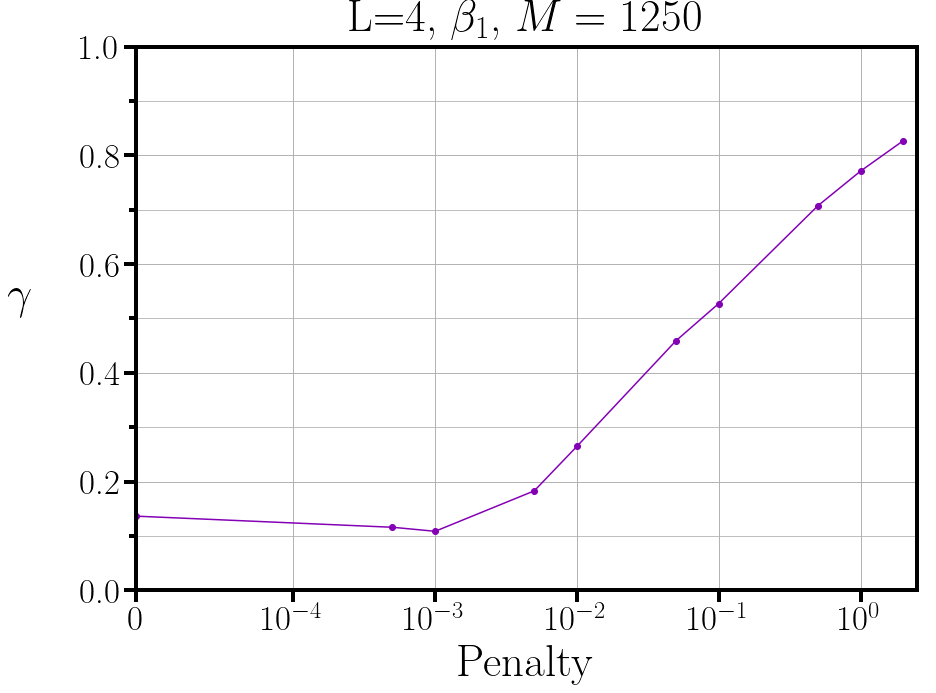

In [209]:
final_errors = [result1[2][-1], result2[2][-1], result3[2][-1], result4[2][-1], result5[2][-1],
                result6[2][-1], result7[2][-1], result8[2][-1], result9[2][-1], result10[2][-1]]
penalties = [2, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0]

plt.figure(figsize = (14, 10))
ax = plt.axes()
plt.title(r'L=4, $\beta_1$, $M=1250$', fontsize=45, y=1.005)
plt.xlabel(r'Penalty', rotation=0, fontsize=45)
plt.ylabel(r'$\gamma$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.plot(penalties, final_errors, color=colors_sp[0], marker='o')
#plt.yscale('log')
plt.xscale('symlog', linthreshx=1e-4)
plt.ylim(0, 1)
plt.xlim(0, np.max(penalties)+0.5)

ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.legend()
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
plt.savefig('error_L4_T1_M1250_t200_vs_pen.png', bbox_inches = 'tight')
plt.show()

In [190]:
print(result8[0])
print('Error inicial: {}'.format(result8[2][0]))
print('Error final: {}'.format(result8[2][-1]))

[[ 0.05906532 -0.22135976]
 [-0.45766547 -0.15336524]
 [-0.03378875  0.06897041]
 [ 0.83915077  0.60163423]
 [ 0.4729327  -0.25249309]
 [ 0.59085215  0.20143402]
 [ 0.04435085 -0.78827738]
 [ 1.00402576 -0.87924053]
 [-0.5018398  -0.32849327]
 [-0.34728725 -0.67016568]
 [ 0.72321545  0.48283063]
 [-0.25447226  0.68765777]
 [-0.93897471 -1.01994094]
 [ 0.92353969 -0.54964019]
 [-0.10229552  0.90583266]
 [ 0.06516858  0.23502878]]
Error inicial: 1.4514977991252964
Error final: 0.10856461000932383


In [128]:
start = timeit.default_timer()
max_iterations = 200
nbrs = f_nbrs(n)
result1 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result2 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result3 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result4 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result5 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result6 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result7 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result8 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result9 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
result10 = gradient_descent(lambda j: pseudolikelihood_gradient_descent(j, sample1, nbrs=nbrs, temp=t1),
                          lambda j: jacobian_pseudo(j, sample1, nbrs=nbrs, temp=t1),
                          np.random.uniform(-1, 1, size=(n,2)), j1, max_iter=max_iterations)
print('TOTAL TIME:', timeit.default_timer() - start)


TOTAL TIME: 33136.303430067994


In [129]:
print(result1[0])
print('Error inicial: {}'.format(result1[2][0]))
print('Error final: {}'.format(result1[2][-1]))


[[ 0.03005731 -0.0790674 ]
 [-0.37022817 -0.18425438]
 [ 0.01444723  0.01129929]
 [ 0.77223153  0.60062167]
 [ 0.3478171  -0.26507643]
 [ 0.57850286  0.19774104]
 [ 0.14121979 -0.69663027]
 [ 0.94904241 -0.84544365]
 [-0.57855493 -0.2395481 ]
 [-0.38589382 -0.76765704]
 [ 0.69501226  0.40354836]
 [-0.28692596  0.728432  ]
 [-0.95401684 -1.        ]
 [ 0.9375241  -0.65879037]
 [-0.1913396   0.92722285]
 [-0.00643527  0.27475813]]
Error inicial: 1.5133695470577744
Error final: 0.03395170225981004


In [130]:
#write_error_to_file('L4_T1_S1_exp/L4_T1_S1_error_m12500_t800_1.txt', result1[1])
#write_arr_to_file('L4_T1_S1_exp/L4_T1_S1_j_m12500_t800_1.txt', flat_matrix(j1), flat_matrix(result1[0][1]))

In [131]:
#write_error_to_file('L4_T1_S1_error_2.txt', result1[1])
#write_error_to_file('L4_T1_S2_error_2.txt', result2[1])
#write_error_to_file('L4_T1_S3_error_2.txt', result3[1])

In [20]:
from matplotlib import rc
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["mathtext.fontset"] = "cm"

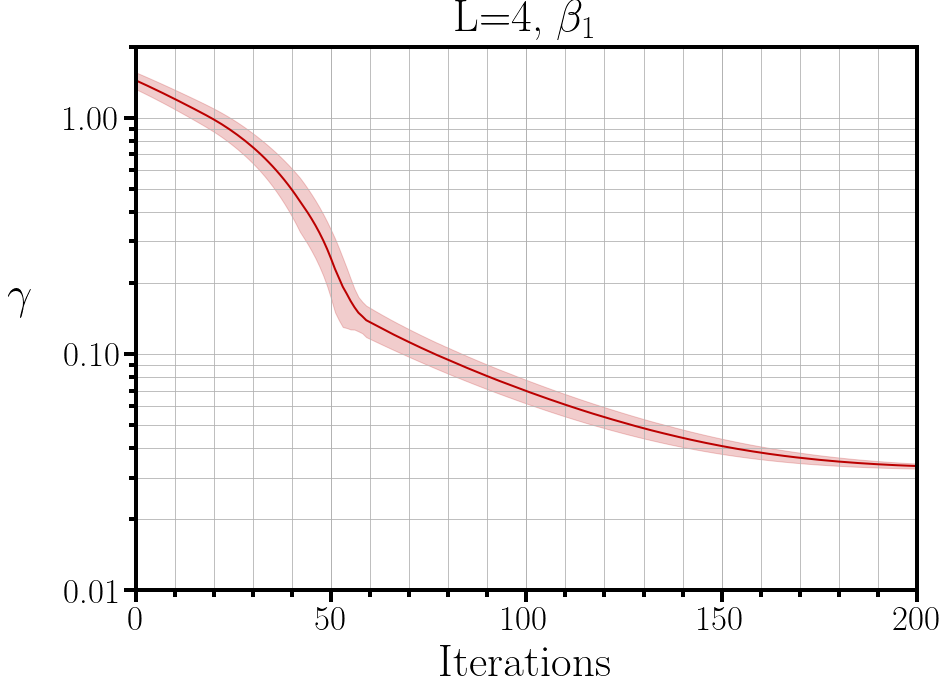

In [136]:
x = np.arange(len(result1[2]))
wl=2
color1, color2, color3 = '#bb0000', '#00bb00', '#0000bb'
plt.figure(figsize = (14, 10))
ax = plt.axes()
plt.title(r'L=4, $\beta_1$', fontsize=45, y=1.005)
plt.xlabel(r'Iterations', rotation=0, fontsize=45)
plt.ylabel(r'$\gamma$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.15, 0.5)
#plt.plot(x, result1[2], color=color1)
#plt.plot(x, result2[2], color=color1)
#plt.plot(x, result3[2], color=color1)
#plt.plot(x, result4[2], color=color1)
#plt.plot(x, result5[2], color=color1)
#plt.plot(x, result6[2], color=color1)
#plt.plot(x, result7[2], color=color1)
#plt.plot(x, result8[2], color=color1)
#plt.plot(x, result9[2], color=color1)
#plt.plot(x, result10[2], color=color1)
avg = np.mean(np.vstack((result1[2],result2[2],result3[2],result4[2],result5[2],result6[2],
                         result7[2],result8[2],result9[2],result10[2])), axis=0)
std = np.std(np.vstack((result1[2],result2[2],result3[2],result4[2],result5[2],result6[2],
                        result7[2],result8[2],result9[2],result10[2])), axis=0, ddof=1)
#write_error_to_file('L4_T1_S1_error_m12500_t200_avg.txt', avg)
#write_error_to_file('L4_T1_S1_error_m12500_t200_std.txt', std)
plt.fill_between(x, avg - std, avg + std, color=color1, alpha=0.2)
plt.plot(x, avg, color=color1, linewidth=wl)
#plt.plot((np.max(x)*0.9, np.max(x)*0.9), (1e-2,2), color='#55ff00', label='y=x', zorder=1, linewidth=3, alpha=1)
#plt.plot(x, result2[1], color='#00bb00')
#plt.plot(x, result3[1], color='#0000bb')
plt.yscale('log')
plt.ylim(1e-2, 2)
plt.xlim(0, np.max(x))

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.legend()
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
#plt.savefig('error_L4_T1_M12500_t200_lin.png', bbox_inches = 'tight')
plt.show()


In [134]:
write_error_to_file('L4_T1_S1_error_m12500_t200_avg.txt', avg)
write_error_to_file('L4_T1_S1_error_m12500_t200_std.txt', std)

In [115]:
print('L4_T1_S1_error:{}'.format(mean_error(h, result1[0][1], h, j1)))
#print('L4_T1_S2_error:{}'.format(mean_error(h, result2[0][1], h, j2)))
#print('L4_T1_S3_error:{}'.format(mean_error(h, result3[0][1], h, j3)))

ValueError: operands could not be broadcast together with shapes (2,) (32,) 

In [ ]:
plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.title('L=4, $T=T_1$', fontsize=45, y=1.005)
plt.xlabel('$J^{0}_{ij}$', rotation=0, fontsize=45)
plt.ylabel('$J_{ij}$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)
plt.plot((-1, 1), (-1,1), color='#55ff00', label='y=x', zorder=1, linewidth=5, alpha=1)
plt.scatter(flat_matrix(j1), flat_matrix(result1[0][1]), color='#ee2222', label='Sample 1', zorder=6, marker="o", s=300)
#plt.scatter(flat_matrix(j2), flat_matrix(result2[0][1]), color='#E8B201', label='Sample 2', zorder=5, marker="v", s=300)
#plt.scatter(flat_matrix(j3), flat_matrix(result3[0][1]), color='#2222ee', label='Sample 3', zorder=4, marker="^", s=300)
#plt.scatter(flat_sym_matrix(j8), flat_sym_matrix(result8[1]), color='#009900', label='N=8', zorder=5, marker="v")
#plt.scatter(flat_sym_matrix(j12), flat_sym_matrix(result12[1]), color='#2222ee', label='N=12', zorder=4, marker="^")
#plt.scatter(flat_sym_matrix(j16), flat_sym_matrix(result16[1]), color='#E8B201', label='N=16', zorder=3, marker="s")
#plt.scatter(flat_sym_matrix(j20), flat_sym_matrix(result20[1]), color='#B300FF', label='N=20', zorder=2, marker="D")

plt.ylim(-1, 1)
plt.xlim(-1, 1)

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.grid()
#plt.legend()
#plt.savefig('L4_T1.png', bbox_inches = 'tight')
plt.show()



In [ ]:
#write_arr_to_file('M25000_L4_T1_S1_j.txt', flat_matrix(j1), flat_matrix(result1[0][1]))
#write_arr_to_file('M25000_L4_T1_S2_j.txt', flat_matrix(j2), flat_matrix(result2[0][1]))
#write_arr_to_file('M25000_L4_T1_S3_j.txt', flat_matrix(j3), flat_matrix(result3[0][1]))

In [ ]:
from skimage import io, exposure, color, img_as_float, img_as_int, img_as_uint, img_as_ubyte
image = io.imread('test2.png')
def two_images(img1, img2, savename):
    io.imsave(savename, np.hstack((img1, img2)))
def three_images(img1, img2, img3, savename):
    io.imsave(savename, np.vstack((img1, img2, img3)))
two_images(image, image, 'test_joined.png')
image = io.imread('test_joined.png')
three_images(image, image, image, 'test_joined_final.png')